In [1]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from keras import Input, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, concatenate
import tensorflow as tf
from keras.models import load_model

sns.set_style('white')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

random_state = 100

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data.csv', delimiter=',')
df = df[df['is_weekend'] == 0]
df = df[df['is_holiday'] == 0]
df.drop(['timestamp', 'is_weekend', 'is_holiday'], inplace = True, axis = 1)
func = lambda h: 6 if h == 0 else min(abs(h - 8), abs(h-18))
for i in range(24):
    print('{0} -> {1}'.format(i, func(i)))

df['hour'] = df['hour'].apply(func)

df.head(10)

0 -> 6
1 -> 7
2 -> 6
3 -> 5
4 -> 4
5 -> 3
6 -> 2
7 -> 1
8 -> 0
9 -> 1
10 -> 2
11 -> 3
12 -> 4
13 -> 5
14 -> 4
15 -> 3
16 -> 2
17 -> 1
18 -> 0
19 -> 1
20 -> 2
21 -> 3
22 -> 4
23 -> 5


month  hour   t1   t2   hum  wind_speed  weather_code  season   cnt
24      1     6  4.0  3.0  93.0         6.0             4       3    83
25      1     7  4.0  3.5  93.0         5.0             4       3    67
26      1     6  5.0  4.0  87.0         6.0             4       3    32
27      1     5  6.0  4.5  84.0         7.5             4       3    22
28      1     4  6.5  5.0  84.0         8.0             4       3    38
29      1     3  6.0  5.5  87.0         5.0             4       3    81
30      1     2  7.0  6.5  81.0         5.0             3       3   444
31      1     1  7.0  6.0  81.0         6.5             3       3  1597
32      1     0  8.0  7.5  79.0         5.0             3       3  3161
33      1     1  8.0  7.0  82.0         6.0             3       3  1342

In [3]:
eight_cats = df.columns[:-1]
eight_cats

Index(['month', 'hour', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'season'],
      dtype='object')

In [4]:
def normalize_df(data_frame):
    normalized = pd.DataFrame()
    for column in df.columns:
        mean = data_frame[column].mean()
        stddev = data_frame[column].std()
        normalized[column] = (data_frame[column] - mean) / stddev
    return normalized


# sample_amount = 1000

sampled_df = df #df.sample(n=sample_amount, random_state=random_state)
normalized_df = normalize_df(df)
normalized_sampled_df = normalized_df #normalize_df(sampled_df)


## Correlation Heatmap

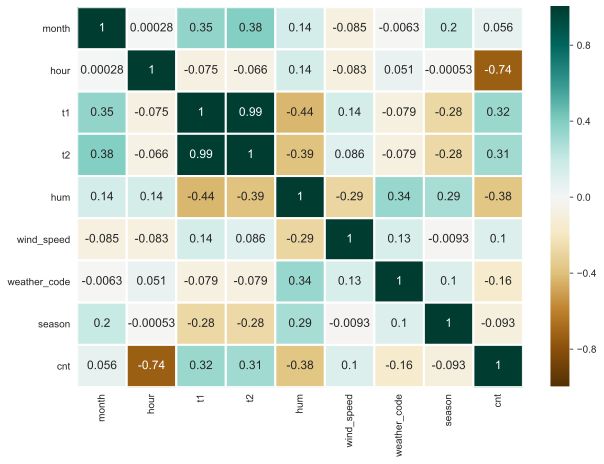

In [16]:
plt.figure(figsize=(10, 7))
_ = sns.heatmap(df.corr(), linecolor='white', linewidths=2.0, annot=True, cmap='BrBG', annot_kws={"size": 12}, vmin=-1.0, vmax=1.0)
plt.savefig('correlation.png', dpi=300, bbox_inches ='tight')

## Feature Correlation to Value

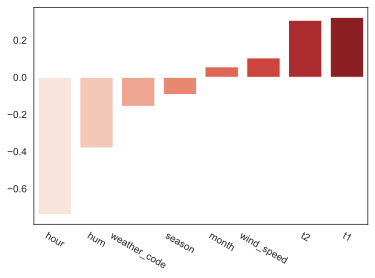

In [6]:
correlation = df.corr()['cnt'].sort_values()[:-1]
chart = sns.barplot(x = correlation.index, y = correlation.values, palette='Reds')
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation = -30)

## Feature to Value Plots

In [7]:

sample_amount = 1000
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
sampled_df2 = df.sample(n=sample_amount, random_state=random_state)
chart = sns.pairplot(data=sampled_df2, x_vars=df.columns, y_vars=df.columns, kind="reg", plot_kws={'scatter_kws' : {'color' : 'cyan', 's' : 15, 'alpha' : 0.2}})
chart.map_upper(hide_current_axis)
plt.savefig('pairplot.png', dpi=300)

## Histogram of Values

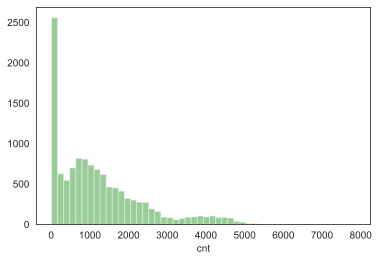

In [8]:
_ = sns.distplot(df['cnt'], bins = 50, kde=False, color='green')

## Neural Network Training

In [9]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = normalized_sampled_df.sample(frac=train_precent, random_state=random_state)
test_data = normalized_sampled_df.drop(train_data.index)

train_x = train_data.drop('cnt', axis = 1)
train_y = train_data['cnt']
test_x = test_data.drop('cnt', axis = 1)
test_y = test_data['cnt']


In [10]:
def build_fully_NN_model(train):
    input_layer    = Input(shape=(train.shape[1],))
    hidden_layer_1 = Dense(10, activation=tf.nn.relu)(input_layer)
    hidden_layer_2 = Dense(10, activation=tf.nn.relu)(hidden_layer_1)
    output_layer   = Dense(1)(hidden_layer_2)

    model = Model(inputs=[input_layer], outputs=[output_layer])

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

def train_model(model, X, y):
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    callbacks=[mc, es]
    history = model.fit(X, y, epochs=800, validation_split = 0.2, verbose=0, callbacks=callbacks)
    model = load_model('best_nn_model.nn')
    return history, model

In [11]:
runs_amount = 5
runs = dict()
all_features_label = 'all features'
runs[all_features_label] = []
for i in range(runs_amount):
    fully_NN_model = build_fully_NN_model(train_x)
    fully_NN_history, fully_NN_model = train_model(fully_NN_model, train_x, train_y)
    mse = fully_NN_model.evaluate(test_x, test_y, verbose=0)
    runs[all_features_label].append(mse)
    print('.', end='')

runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)

.....

In [12]:
def build_halved_model(group1, group2, group3, group4):
    input1 = Input(shape=(len(group1),))
    hidden1_1 = Dense(4, activation='relu')(input1)
    hidden1_2 = Dense(4, activation='relu')(hidden1_1)
    out1 = Dense(1)(hidden1_2)

    input2 = Input(shape=(len(group2),))
    hidden2_1 = Dense(4, activation='relu')(input2)
    hidden2_2 = Dense(4, activation='relu')(hidden2_1)
    out2 = Dense(1)(hidden2_2)

    input3 = Input(shape=(len(group3),))
    hidden3_1 = Dense(4, activation='relu')(input3)
    hidden3_2 = Dense(4, activation='relu')(hidden3_1)
    out3 = Dense(1)(hidden3_2)

    input4 = Input(shape=(len(group4),))
    hidden4_1 = Dense(4, activation='relu')(input4)
    hidden4_2 = Dense(4, activation='relu')(hidden4_1)
    out4 = Dense(1)(hidden4_2)

    merge = concatenate([out1, out2, out3, out4], name='merge')
    output = Dense(1)(merge)

    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model
def calc_halved_NN_mse(g1, g2, g3, g4):
    halved_train_X = [train_x[g1], train_x[g2], train_x[g3], train_x[g4]]
    halved_train_Y = train_y
    halved_test_X = [test_x[g1], test_x[g2], test_x[g3], test_x[g4]]
    halved_test_Y = test_y
    name = (str(g1), str(g2), str(g3), str(g4))
    runs[name] = []
    for i in range(runs_amount):
        halved_model = build_halved_model(g1, g2, g3, g4)
        _, halved_model = train_model(halved_model, halved_train_X, halved_train_Y)
        mse = halved_model.evaluate(halved_test_X, halved_test_Y, verbose=0)
        runs[name].append(mse)
    return name

In [13]:
iteration = 0

def is_lower(g1, g2):
    val1 = g1[0] * 8 + g1[1]
    val2 = g2[0] * 8 + g2[1]
    return val1 < val2

def is_unique(g1, g2, g3, g4):
    vals = g1 + g2 + g3 + g4
    return len(vals) == len(set(vals))

def all_2_2_2_2():
    all_combinations = list(itertools.combinations(list(range(8)), 2))
    combinations = []
    for g1 in all_combinations:
        for g2 in all_combinations:
            if is_lower(g1, g2):
                for g3 in all_combinations:
                    if is_lower(g2, g3):
                        for g4 in all_combinations:
                            if is_lower(g3, g4):
                                if is_unique(g1, g2, g3, g4):
                                    combinations.append((g1, g2, g3, g4))
    return combinations

In [14]:
corr = df.corr().values

def get_corr(subset):
    return corr[subset[0], subset[1]]
for subset1, subset2, subset3, subset4 in all_2_2_2_2():
    g1 = [eight_cats[i] for i in subset1]
    g2 = [eight_cats[i] for i in subset2]
    g3 = [eight_cats[i] for i in subset3]
    g4 = [eight_cats[i] for i in subset4]

    name = calc_halved_NN_mse(g1, g2, g3, g4)

    runs[name].append(get_corr(subset1))
    runs[name].append(get_corr(subset2))
    runs[name].append(get_corr(subset3))
    runs[name].append(get_corr(subset4))
    print('.', end= '')
    iteration += 1
    pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results' + str(iteration) + '.csv')


.........................................................................................................